## Đây là giải pháp đơn giản để dự đoán 1 người là còn sống hay đã chết trong vụ đắm tàu Titanic.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline

### Thu thập dữ liệu:

In [2]:
# đọc dữ liệu từ file .csv truyền vào Data Frame.
train = pd.read_csv("C:/Users/Administrator/python/Titanic/input/train.csv")
test = pd.read_csv("C:/Users/Administrator/python/Titanic/input/test.csv")
# tổng hợp 2 bộ test để điều chỉnh dữ liệu cho cả 2
combine = [train, test]

Mô tả các feature có trong dataset. Phân loại xem chúng thuộc Numerical, Categorical, hay Text.

In [3]:
print(train.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


Categorical: Nominal: Survived, Sex, and Embarked; Ordinal: Pclass.

Numerical: Continous: Age, Fare. Discrete: SibSp, Parch.

In [4]:
# Xem trước dữ liệu
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Các feature nào chứa kiểu dữ liệu hỗn hợp: Ticket là dữ liệu kết hợp giữa numeric và alphanumeric. Cabin là alphanumeric.

Các feature nào có thể chứa lỗi: feature "Name".

Các feature nào chứa giá trị blank, null or empty, nếu có thì phải điền giá trị vào những vị trí đó: Cabin, Age, Embarked.

Có 7 feature là int hoặc float(6 đối với test dataset), 5 feature là string(object).

In [5]:
# xem thông tin
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
# xem mô tả của numerical feature
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
# xem mô tả của categorical feature
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Hassan, Mr. Houssein G N",male,1601,B96 B98,S
freq,1,577,7,4,644


Xem các giá trị của numerical feature và categorical feature phân bố như nào? Từ đó rút ra nhận xét sơ bộ về các feature đó.

Xem xét mối tương quan giữa các feature. Feature nào có nhiều ảnh hưởng đến Survival? Feature nào không ảnh hưởng đến Survival?

In [8]:
# Xem xét ảnh hưởng của feature "Sex" đến "Survival".
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


### Điều chỉnh dữ liệu:

Lấp đầy những chỗ trống trong "Age" và "Embarked" vì nó có ảnh hưởng đến Survival. Lưu ý chỉ nên điền vào những feature nào có ít giá trị trống, nếu có quá nhiều giá trị trống thì khi điền vào như vậy sẽ làm cho dự đoán không chính xác. Ví dụ như không nên sửa chữa feature "Cabin" vì nó có quá nhiều giá trị trống.

In [9]:
# Chọn giá trị phổ biến nhất để điền vào chỗ trống trong feature "Embarked" của train dataset.
freq_port = train.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [10]:
# Lấy giá trị trung bình của "Age" để điền vào chỗ trống.
for dataset in combine:
    dataset['Age'] = dataset['Age'].fillna(dataset['Age'].median())

In [11]:
# Vì chỉ có 1 giá trị trống nên ta thay thế ngay tại chỗ với `inplace=True` ở test dataset
test['Fare'].fillna(test['Fare'].dropna().median(), inplace=True)

Xem xét loại các feature sau:

Ticket bị loại vì có tỷ lệ trùng lặp cao và ko có tương quan với Survival.

Cabin có thể bị loại vì có nhiều giá trị trống.

PassengerId và Name có thể bị loại vì ko liên quan đến Survival.

Chuyển đổi Categorical feature sang Numerical feature.

In [12]:
# chuyển đổi giá trị "male" = 0 và "female" = 1
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male': 0}).astype(int)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


In [13]:
# chuyển đổi giá trị 'S' = 0, 'C' = 1, 'Q' = 2
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0


Phân tích và tạo ra những feature mới từ những feature có sẵn. Những feature mới này phải có ảnh hưởng đến dự đoán "Survival".

Nhìn vào feature 'Age' ta thấy có quá nhiều giá trị nên không thấy được mỗi giá trị sẽ ảnh hưởng như nào đến 'Survival'. Vì thế ta muốn tạo ra các khoảng tuổi tác 'AgeBand' để gom giá trị tuổi lại, từ đó xem được với mỗi khoảng tuổi thì 'Survival' sẽ như thế nào.

In [14]:
# chuyển 'Age' từ float sang int
for dataset in combine:
    dataset['Age'] = dataset['Age'].astype(int)

In [15]:
# chia 'Age' thành 5 nửa khoảng mà mỗi nửa khoảng tương ứng với 1 giá trị của feature mới 'AgeBand'
train['AgeBand'] = pd.cut(train['Age'], 5)
train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.344762
2,"(32.0, 48.0]",0.403226
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [16]:
#Thay mỗi giá trị 'Age' bằng thứ tự của 'AgeBand'
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBand
0,1,0,3,"Braund, Mr. Owen Harris",0,1,1,0,A/5 21171,7.2500,NaN,0,"(16.0, 32.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,PC 17599,71.2833,C85,1,"(32.0, 48.0]"
2,3,1,3,"Heikkinen, Miss. Laina",1,1,0,0,STON/O2. 3101282,7.9250,NaN,0,"(16.0, 32.0]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,113803,53.1000,C123,0,"(32.0, 48.0]"
4,5,0,3,"Allen, Mr. William Henry",0,2,0,0,373450,8.0500,NaN,0,"(32.0, 48.0]"


Bây giờ ta thấy feature 'AgeBand' không còn tác dụng để dự đoán nữa vì mỗi giá trị 'Age' lúc này đã tương ứng với 'AgeBand' nên chỉ cần 'Age' là đủ. Nhưng chúng ta cũng không nên xóa 'AgeBand' vì nếu xóa thì khi nhìn vào feature 'Age' ta không hiểu chúng có nghĩa là gì.

### Lựa chọn mô hình tốt nhất để huấn luyện và dự đoán.

Sử dụng mô hình Random Forest:

In [17]:
# tạo dữ liệu train và test
X_train = train[["Pclass", "Age", "Sex", "Fare", "SibSp", "Parch", "Embarked"]].values
Y_train = train["Survived"].values
X_test = test[["Pclass", "Age", "Sex", "Fare", "SibSp", "Parch", "Embarked"]].values
# Sử dụng model Random Forest với các tham số tùy chỉnh
random_forest = RandomForestClassifier(max_depth=10, min_samples_split=2, n_estimators=100, random_state=1)
random_forest.fit(X_train, Y_train)
# Dự đoán 'Survival' sống hay chết?
Y_pred = random_forest.predict(X_test)
# Tỉ lệ dự đoán đúng
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(acc_random_forest)

92.37


Ta có thể giảm độ phức tạp của model để tránh bị overfitting bằng regularization lên các feature không quan trọng hoặc ít quan trọng đến kết quả dự đoán.

In [18]:
# đánh giá độ quan trọng của mỗi feature
rf_feature = random_forest.feature_importances_
rf_feature

array([ 0.11019791,  0.08506783,  0.34037257,  0.30274148,  0.0654107 ,
        0.05522584,  0.04098368])

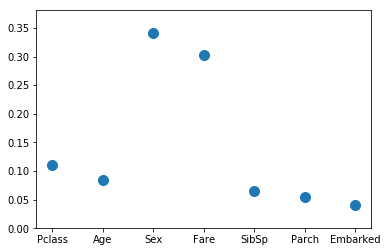

In [19]:
# Vẽ đồ thị scatter cho feature importances
feature = [i for i in range(7)]
plt.scatter(feature, rf_feature, s=100)
tick_lab = ["Pclass", "Age", "Sex", "Fare", "SibSp", "Parch", "Embarked"]
plt.xticks(feature, tick_lab)
plt.show()

Phải thử với các mô hình khác nhau để tìm ra được mô hình phù hợp nhất với bài toán của mình.